# **NLP Cleaning and EDA**

### **By:** Jiro Amato

### **Date:** May, 30, 2024

---

In this notebook, we wll be going through a first pass of preprocessing our training dataset for the sentiment analysis model. This dataset contains 4,840 financial articles that have been classified as positive, neutral or negative by 16 financial professionals. It is crucial to complete this step as it sets the foundation for the rest of the model. We will be looking through text-preprocessing and some EDA using techniques such as Bag of Words and TF-IDF to vecotrize the text data.

### Data Dictionary

**Column Name:**   

- `Headline:` The headline of the news article
- `Sentiment:` Classifications by positive, neutral or negative. These classifications were agreed upon by 16 professionals in the Finance domain.

TOC TBD

In [29]:
# Importing necessary libraries

# Libraries for data manipulation
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#  ML related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Scalers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# For memory caching
from tempfile import mkdtemp

# For Train/Test splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# NLP specific libraries
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
df = pd.read_csv('../data/df_clean.csv', index_col=0)
df.head()

,Headline,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [31]:
# Mapping sentiments into binary (consolidating neutral into negative)

df['Sentiment'] = np.where(df['Sentiment'] == 'positive', 1, 0)

# Sanity check
df['Sentiment'].value_counts()

Sentiment
0    3477
1    1363
Name: count, dtype: int64

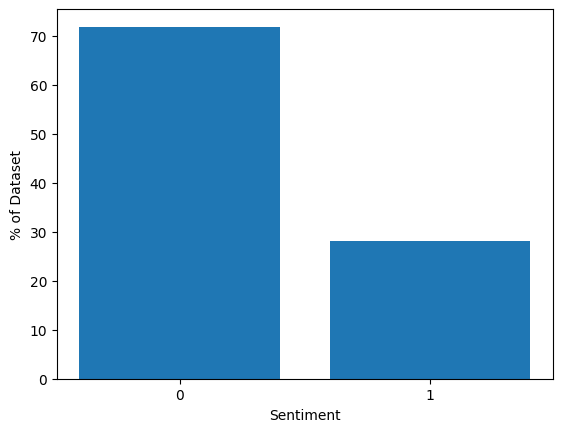

Class imbalance: [0.72 0.28]


In [32]:
# Class imbalance

values, counts = np.unique(df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Sentiment')
plt.ylabel('% of Dataset')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

From the `1-NLP-Cleaning-EDA` notebook we created our own tokenizer. The components are below:

1. Standardization: Transforming text data into all lowercase and take out the punctuations
2. Tokenization: Splitting the documents into individual words
3. Stop-word removal: Removing words without significant meaning such as 'the' and 'like'
4. Lemmatization: Reducing words to their lemma (root)
5. Removal of short tokens with 1 or 2 elements

In [33]:
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def my_tokenizer(sentence):
    # transform string into lower case and take out punctuations
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '').lower()

    # tokenization
    listofwords = sentence.split(' ')
    lemmatized_words = []

    # removal of stop-words
    for word in listofwords:
        if word not in stop_words and (word != ''):
            # lemmatizing
            lemma = wnl.lemmatize(word)
            lemmatized_words.append(lemma)
            
    # Removing any other words with 1 or 2 letters that are insignificant        
    tokenized_list = [word for word in lemmatized_words if (len(word) != 1) and (len(word) != 2)]

    return tokenized_list

In [34]:
# Extracting columns

X = df['Headline']
y = df['Sentiment']

# Vectorizing
bagofwords = CountVectorizer(min_df=5, tokenizer=my_tokenizer, ngram_range=(1, 1))

# Fitting
bagofwords.fit(X)
X_bow = bagofwords.transform(X)

X_bow = pd.DataFrame(data=X_bow.toarray(), columns=bagofwords.get_feature_names_out())

X_bow

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,000,021,050,100,1000,10000,100000,105,110,112,...,yard,year,yearonyear,yesterday,yet,yit,york,zinc,zone,àland
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4838,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


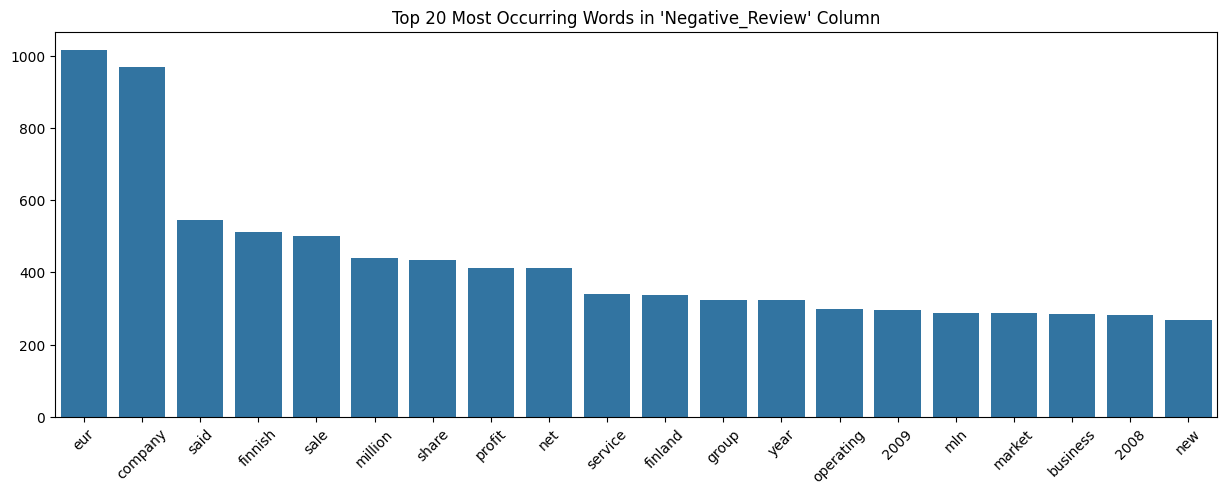

In [35]:
# Plotting most occuring words in 'Negative_Review'
plt.figure(figsize=(15,5))
sns.barplot(X_bow.sum(axis=0).sort_values(ascending=False).head(20))
plt.title('Top 20 Most Occurring Words in \'Negative_Review\' Column')
plt.xticks(rotation=45)
plt.show()

In [78]:
# Train/Test Split

X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

In [79]:
# Creating a fold_scores variable in order to streamline processing folds:
def fold_scores(X: pd.DataFrame, y: pd.DataFrame,
                train_index: np.ndarray,
                validation_index: np.ndarray,
                C: float):
        """This function generates a train and validation scores based on the alpha
        hyperparameter, train/validation indexes and respective independent/target 
        variables from the remainder split.

        Args:
            X (pd.DataFrame): X dataframe. Should be the remainder split.
            y (pd.DataFrame): y dataframe. Should be the remainder split.
            train_index (np.ndarray): An array of indexes to split train set from X and y
            test_index (np.ndarray): An array of indexes to split validation set from X and y
            alpha (float): Sets 'alpha' argument in SGDClassifier() (regularization strength)

        Returns:
            tuple: [float, float]: Returns a tuple of train score and validation score
        """
        # Splitting the remainder
        X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
        
        # Fitting and running the Logistic regression model
        LR_model = LogisticRegression(solver='liblinear',
                                 penalty='l1',
                                 C=C, random_state=1,
                                 max_iter=10000)
        LR_model.fit(X_train, y_train)    
        
        # Train scores:
        training_score = LR_model.score(X_train, y_train)
        
        # Validation scores:
        validation_score = LR_model.score(X_validation, y_validation)
        
        return training_score, validation_score

In [80]:
# The fold variable which splits the remainder data into 5 folds
folds = KFold(n_splits=5, shuffle=True, random_state=1)

# Storing folds
fold_indexes = {fold + 1: (train_index, test_index)
                for fold, (train_index, test_index) in enumerate(folds.split(X_remain))}

# Sanity check
fold_indexes

{1: (array([   0,    1,    2, ..., 3869, 3870, 3871]),
  array([   3,    4,    6,    7,   12,   13,   17,   19,   28,   37,   40,
           45,   50,   58,   60,   65,   72,   75,   79,   83,   89,   93,
           94,   98,   99,  102,  107,  108,  110,  123,  126,  136,  137,
          161,  165,  169,  171,  172,  181,  186,  187,  188,  194,  195,
          201,  203,  205,  210,  219,  220,  224,  230,  254,  255,  256,
          262,  267,  268,  280,  282,  291,  292,  297,  299,  301,  305,
          306,  318,  321,  329,  330,  331,  349,  351,  359,  364,  366,
          368,  372,  382,  385,  386,  393,  397,  398,  399,  403,  407,
          416,  420,  427,  435,  442,  453,  457,  462,  464,  471,  473,
          481,  486,  487,  494,  495,  498,  516,  517,  518,  525,  534,
          535,  540,  541,  546,  551,  555,  557,  558,  560,  563,  573,
          574,  577,  581,  587,  588,  589,  605,  610,  630,  632,  636,
          650,  661,  662,  664,  666,  678, 

In [81]:
# Training and validation set overview
print(f'Training Size: {fold_indexes[1][0].shape} \nValidation_Size: {fold_indexes[1][1].shape}')

Training Size: (3097,) 
Validation_Size: (775,)


| # of folds | training size | validation size |
|:------------:|:---------------:|:-----------------:|
| 5          | 3,097            | 775              |

#### $C=10^{-6}$

In [82]:
# Instantiating a list of cross-validation scores
cross_validation_scores = []

# Average cross-train scores
all_train_scores = []

C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = .000001

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.000001)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.000001)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = .000001 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.7184912490544069 
Cross Validation Score: 0.7184839543219139


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |

#### $C=10^{-5}$

In [83]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = .00001

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.00001)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.00001)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = .00001 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.7184912490544069 
Cross Validation Score: 0.7184839543219139


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |

#### $C=10^{-4}$

In [84]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = .0001

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.0001)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.0001)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = .0001 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.7184912490544069 
Cross Validation Score: 0.7184839543219139


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |

#### C = $10^{-3}$

In [85]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = .001

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.001)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=.001)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = .001 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.7184912490544069 
Cross Validation Score: 0.7184839543219139


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |

#### $C=10^{-2}$

In [86]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 0.01

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=0.01)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=0.01)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 0.01 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.7184912490544069 
Cross Validation Score: 0.7184839543219139


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |

#### $C=10^{-1}$

In [87]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 0.1

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=0.1)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=0.1)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 0.1 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.7687887213786724 
Cross Validation Score: 0.7587770275902309


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |

#### $C=10^{0}$

In [88]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 1

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=1)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=1)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 1 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.9006329872533302 
Cross Validation Score: 0.8073338334583646


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |
|   $10^0$   | 0.901                                     | 0.807 | L1 |

#### $C=10^1$

In [89]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 10

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=10)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=10)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 10 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.9925103804197946 
Cross Validation Score: 0.7587813620071684


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |
|   $10^0$   | 0.901                                     | 0.807 | L1 |
|   $10^1$   | 0.993                                    | 0.759 | L1 |

#### $C=10^2$

In [90]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 100

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=100)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=100)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 100 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.9976109869544091 
Cross Validation Score: 0.7396735850629325


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |
|   $10^0$   | 0.901                                     | 0.807 | L1 |
|   $10^1$   | 0.993                                    | 0.759 | L1 |
|   $10^2$   | 0.998                                    | 0.740 | L1 |

#### $C=10^3$

In [91]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 1000

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=1000)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=1000)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 1000 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.9992897810476119 
Cross Validation Score: 0.7241813786780028


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |
|   $10^0$   | 0.901                                     | 0.807 | L1 |
|   $10^1$   | 0.993                                    | 0.759 | L1 |
|   $10^2$   | 0.998                                    | 0.740 | L1 |
|   $10^3$   | 0.999                                    | 0.724 | L1 |

#### $C=10^4$

In [92]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 10000

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=10000)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=10000)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 10000 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.999483496075775 
Cross Validation Score: 0.7048145369675753


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |
|   $10^0$   | 0.901                                     | 0.807 | L1 |
|   $10^1$   | 0.993                                    | 0.759 | L1 |
|   $10^2$   | 0.998                                    | 0.740 | L1 |
|   $10^3$   | 0.999                                    | 0.724 | L1 |
|   $10^4$   | 0.999                                    | 0.705 | L1 |

#### $C=10^5$

In [93]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 100000

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=100000)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=100000)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 100000 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.999483496075775 
Cross Validation Score: 0.7058424606151539


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |
|   $10^0$   | 0.901                                     | 0.807 | L1 |
|   $10^1$   | 0.993                                    | 0.759 | L1 |
|   $10^2$   | 0.998                                    | 0.740 | L1 |
|   $10^3$   | 0.999                                    | 0.724 | L1 |
|   $10^4$   | 0.999                                    | 0.705 | L1 |
|   $10^5$   | 0.999                                    | 0.706 | L1 |

#### $C=10^6$

In [94]:
# A list of training and validation scores for each hyperparameter C.
train_scores = []
val_scores = []

# At C = 1000000

for fold in fold_indexes:
    # Retrieving the train and validation scores at each fold
    t_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=1000000)[0]
    v_score = fold_scores(X_remain, y_remain, fold_indexes[fold][0], fold_indexes[fold][1], C=1000000)[1]
    
    # Appending the scores to the overall list
    train_scores.append(t_score)
    val_scores.append(v_score)

# Taking the mean of all the validation and train scores for C = 1000000 and adding it to our lists
cross_validation_scores.append(np.mean(val_scores))
all_train_scores.append(np.mean(train_scores))

print(f'Train Score: {all_train_scores[-1]} \nCross Validation Score: {cross_validation_scores[-1]}')

Train Score: 0.999483496075775 
Cross Validation Score: 0.6957719429857464


***Cross Validation Scores at each C***: <br>
 
| C | Train Score                                 | Cross Validation Score    | Penalty    |
|-------|--------------------------------------------|-------|-------|
|   $10^{-6}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-5}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-4}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-3}$   | 0.718                                     | 0.718 | L1 |
|   $10^{-2}$   | 0.718                                    | 0.718 | L1 |
|   $10^{-1}$   | 0.769                                     | 0.759 | L1 |
|   $10^0$   | 0.901                                     | 0.807 | L1 |
|   $10^1$   | 0.993                                    | 0.759 | L1 |
|   $10^2$   | 0.998                                    | 0.740 | L1 |
|   $10^3$   | 0.999                                    | 0.724 | L1 |
|   $10^4$   | 0.999                                    | 0.705 | L1 |
|   $10^5$   | 0.999                                    | 0.706 | L1 |
|   $10^6$   | 0.999                                    | 0.696 | L1 |

### Choosing the best Logistic Regression Model

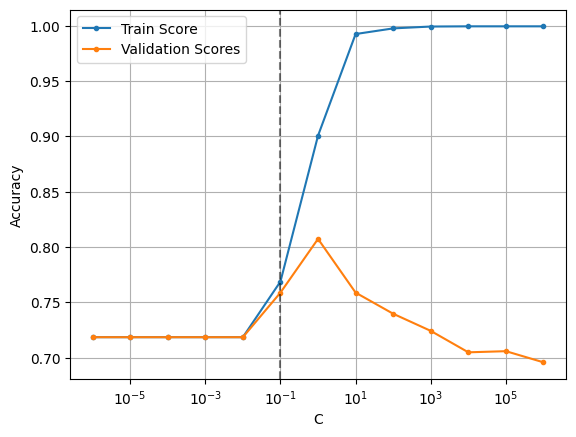

In [103]:

# Plotting results

C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

plt.figure()
plt.plot(C_range, all_train_scores, label='Train Score', marker='.')
plt.plot(C_range, cross_validation_scores, label='Validation Scores', marker='.')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.axvline(0.1, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

Here we can see that the highest validation accuracy is when $C=1$. However, the model is severely overfitting with train score at 0.993 and validation score at 0.759. The closest point from $C=10$ where train and validation accuracy is closest is $C=10^{-1}$. Here the model gives us comparable poerformance with train score being 0.769 and validation score being 0.759.

Now I will fit the Logistic Regresion Model where $C=10^{-1}$ and $Penalty=L1$

In [104]:
LR_model = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, max_iter=10000, random_state=1)
LR_model.fit(X_remain, y_remain)

# Train score
LR_model_train_score = LR_model.score(X_remain, y_remain)

# Test score
LR_model_test_score = LR_model.score(X_test, y_test)

print(f'Train Score: {LR_model_train_score} \nTest Score: {LR_model_test_score}')

Train Score: 0.7778925619834711 
Test Score: 0.7820247933884298


The best logistic regression model is as follows:

| C | Penalty                                 | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|-------|
| $10^{-1}$   | L1     | 0.759 | 0.778  | 0.782   |

In [55]:
train_scores = []
test_scores = []

C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

for C in C_range:
    LR_model = LogisticRegression(solver='liblinear', penalty='l1', C=C, max_iter=10000, random_state=1)
    LR_model.fit(X_remain, y_remain)
    
    # Train Score
    train_scores.append(LR_model.score(X_remain, y_remain))
    test_scores.append(LR_model.score(X_test, y_test))

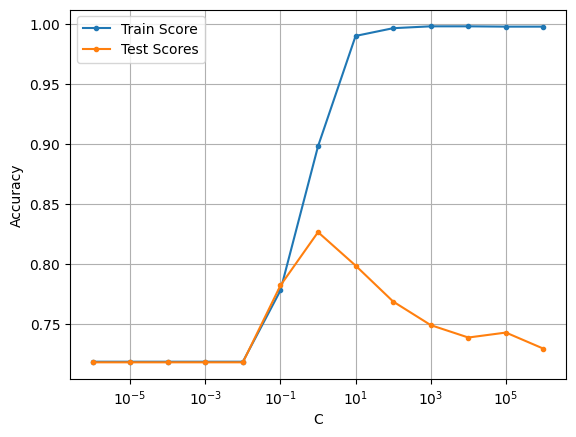

In [75]:
C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

plt.figure()
plt.plot(C_range, train_scores, label='Train Score', marker='.')
plt.plot(C_range, test_scores, label='Test Scores', marker='.')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

## Decision Tree

In [112]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

depths = list(range(1, int(np.sqrt(len(X_remain)))))

cross_validation_scores_DT = []
all_train_scores_DT = []

for depth in depths:
    DT = DecisionTreeClassifier(max_depth=depth, random_state=1)
    
    # Train and cross validation scores
    cv_score = np.mean(cross_validate(DT, X_remain, y_remain, cv=5, return_train_score=True)['test_score'])
    train_score = np.mean(cross_validate(DT, X_remain, y_remain, cv=5, return_train_score=True)['train_score'])
    
    # Append to overall list
    cross_validation_scores_DT.append(cv_score)
    all_train_scores_DT.append(train_score)

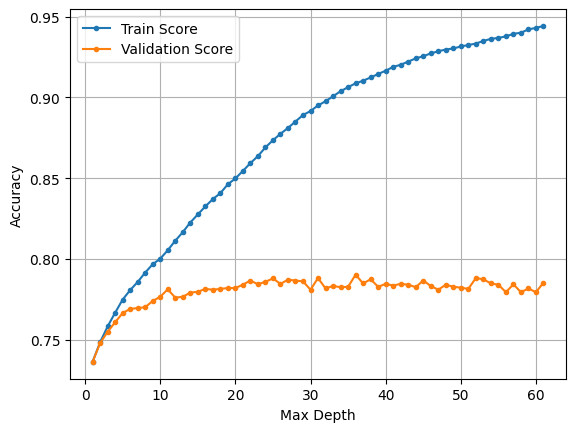

In [113]:
plt.figure()
plt.plot(depths, all_train_scores_DT, label="Train Score", marker=".")
plt.plot(depths, cross_validation_scores_DT, label="Validation Score", marker=".")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

In [114]:
# Cross Validation Score
DT = DecisionTreeClassifier(max_depth=11, random_state=1)
cross_val_score = np.mean(cross_validate(DT, X_remain, y_remain, cv=5)['test_score'])
cross_val_score

0.7812509794115196

In [115]:
DT = DecisionTreeClassifier(max_depth=11, random_state=1)
DT.fit(X_remain, y_remain)

# Scores
DT_train_score = DT.score(X_remain, y_remain)
DT_test_score = DT.score(X_test, y_test)

print(f'Train Score: {DT_train_score} \nTest Score: {DT_test_score}')

Train Score: 0.8029442148760331 
Test Score: 0.8099173553719008


The best Decision Tree model is as follows:

| Max Depth | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 11   | 0.781 | 0.803  | 0.810   |

## KNN

In [126]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)


k_values = list(range(1, 40, 2))

cross_validation_scores_KNN = []
all_train_scores_KNN = []

for k in k_values:
    KNN = Pipeline([("scaler", StandardScaler()),
                    ("model", KNeighborsClassifier(n_neighbors=k))])
    
    # Train and cross validation scores
    cv_score = np.mean(cross_validate(KNN, X_remain, y_remain, cv=5)['test_score'])
    train_score = np.mean(cross_validate(KNN, X_remain, y_remain, cv=5, return_train_score=True)['train_score'])
    
    # Append to overall list
    cross_validation_scores_KNN.append(cv_score)
    all_train_scores_KNN.append(train_score)

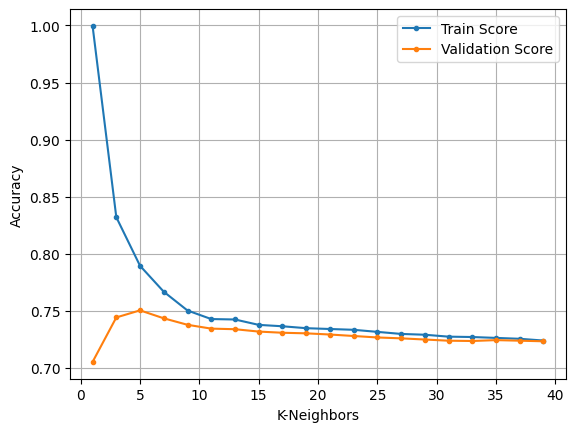

In [127]:
plt.figure()
plt.plot(k_values, all_train_scores_KNN, label="Train Score", marker=".")
plt.plot(k_values, cross_validation_scores_KNN, label="Validation Score", marker=".")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

In [128]:
# Cross Validation Score
KNN = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsClassifier(n_neighbors=5))])
cross_val_score = np.mean(cross_validate(KNN, X_remain, y_remain, cv=5)['test_score'])
cross_val_score

0.7502538968075352

In [129]:
# Final Model

KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_remain, y_remain)

# Scores
KNN_train_score = DT.score(X_remain, y_remain)
KNN_test_score = DT.score(X_test, y_test)

print(f'Train Score: {KNN_train_score} \nTest Score: {KNN_test_score}')

Train Score: 0.8029442148760331 
Test Score: 0.8099173553719008


The best KNN model is as follows:

| K-Neighbours | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 5   | 0.750 | 0.803  | 0.810   |

In [130]:
y

0       0
1       1
2       1
3       1
4       1
       ..
4835    0
4836    0
4837    1
4838    0
4839    0
Name: Sentiment, Length: 4840, dtype: int32

## Naive-Bayes

In [131]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

alpha_values = list(range(1, 20))

cross_validation_scores_NB = []
all_train_scores_NB = []

for alpha in alpha_values:
    NB = MultinomialNB(alpha=alpha)
    
    # Train and cross validation scores
    cv_score = np.mean(cross_validate(NB, X_remain, y_remain, cv=5)['test_score'])
    train_score = np.mean(cross_validate(NB, X_remain, y_remain, cv=5, return_train_score=True)['train_score'])
    
    # Append to overall list
    cross_validation_scores_NB.append(cv_score)
    all_train_scores_NB.append(train_score)

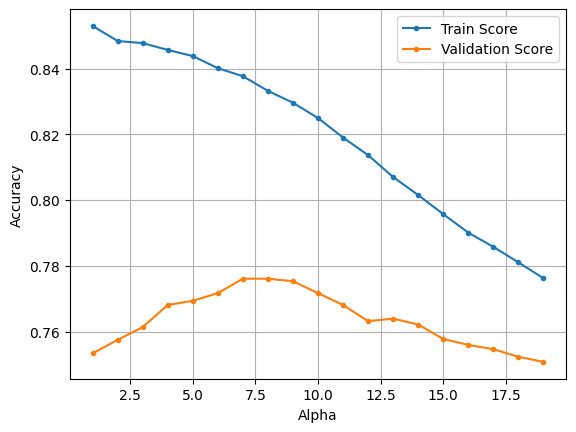

In [132]:
plt.figure()
plt.plot(alpha_values, all_train_scores_NB, label="Train Score", marker=".")
plt.plot(alpha_values, cross_validation_scores_NB, label="Validation Score", marker=".")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()